# Polynômes de chaos : application au cas de la poutre encastrée


## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment obtenir les indices de Sobol' à partir d'un chaos polynomial.

# Problem statement

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\}$
* $E$ : Young modulus (Pa)
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4),
* $F$ : Loading (N)

|Variable|  Distribution|
| ------------- |-------------|
|E|  Beta(r = 0.9, t = 3.5, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu=3 \times 10^4$, $\sigma=9\times 10^3$)|
|L|Uniform(min=250.0, max= 260.0)|
|I| Beta(r = 2.5, t = 4.0, a = 310, b = 450)|

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

# Model definition

In [1]:
import openturns as ot
import pylab as plt
import numpy as np

In [2]:
dist_E = ot.Beta(0.9, 3.1, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250., 260.) # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 4, 310., 450.) # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [3]:
dim_input = 4 # dimension of the input
dim_output = 1 # dimension of the output

def function_beam(X):
    E, F, L, I = X
    Y = F* (L**3) /  (3 * E * I)
    return [Y]

g = ot.PythonFunction( dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create the polynomial chaos decomposition

On crée la base polynomiale multivariée par tensorisation avec la règle d'énumération linéaire par défaut.

In [4]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory([dist_E, dist_F, dist_L, dist_I])

* Experimental design: training sample
* LARS (Least angle regression): selection of relevant polynomials
* CorrectedLeaveOneOut (or KFold): error indicator
* Truncation strategy: how many polynomials to be considered

Generate an experimental design (training sample) of size N with MC simulation (or in a more generale case, retrieve the ED from experimental data)

In [5]:
N = 50 # size of the experimental design

inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)

Least squares method with LARS and CorrectedLeaveOneOut. 

In [6]:
approximationAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()

Par défaut, c'est l'algorithme de sélection de modèle LARS qui est utilisé.

In [7]:
approximationAlgorithm.getBasisSequenceFactory()

class=LARS

Par défaut, c'est le critère de leave-one-out (corrigé) qui est utilisé par la méthode de sélection de modèle.

In [8]:
approximationAlgorithm.getFittingAlgorithm()

class=CorrectedLeaveOneOut

Define the least-squares evalution strategy

In [9]:
evalStrategy = ot.LeastSquaresStrategy(inputTrain, outputTrain, approximationAlgorithm)

Nous devons une règle de troncature : ici, nous avons choisit la `FixedStrategy`, ce qui revient à conserver les `P` premiers polynômes de la base de polynômes. Dans notre cas particulier, nous avons déterminé `P` en utilisant la méthode  `getStrataCumulatedCardinal`, de telle sorte que c'est l'ensemble des polynômes multivariés de degré total inférieur ou égal à 5 qui est conservé. 

In [10]:
totalDegree = 5
enumfunc = multivariateBasis.getEnumerateFunction()
P = enumfunc.getStrataCumulatedCardinal(totalDegree)
truncationBasisStrategy = ot.FixedStrategy(multivariateBasis, P)
truncationBasisStrategy

class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=126

On observe que le nombre de polynômes correspondant à notre règle de troncature est égal à 126.

Construct the chaos metamodel

In [11]:
chaosalgo = ot.FunctionalChaosAlgorithm(inputTrain, outputTrain, myDistribution, truncationBasisStrategy, evalStrategy)
chaosalgo.run()

Get the result


In [12]:
result = chaosalgo.getResult() # get the result
type(result)

openturns.metamodel.FunctionalChaosResult

In [13]:
metamodel = result.getMetaModel() # get the metamodel
type(metamodel)

openturns.func.Function

## Validate the metamodel

Generate a validation sample (__which is independent of the training sample__)

In [14]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

Use class MetaModelValidation 

In [15]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictivity coefficient

In [16]:
Q2 = val.computePredictivityFactor()
Q2

0.9935498537159507

Plot the actual vs the predicted outputs

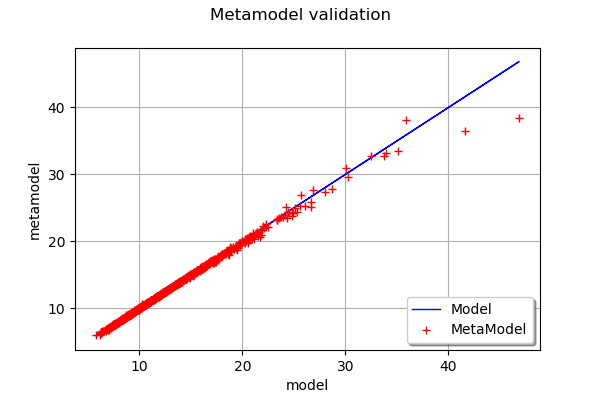

In [17]:
val.drawValidation()

## Sensitivity analysis

Retrieve Sobol' sensitivity measures associated to the polynomial chaos decomposition of the model.

In [18]:
chaosSI = ot.FunctionalChaosSobolIndices(result) 
print( chaosSI.summary() )

 input dimension: 4
 output dimension: 1
 basis size: 25
 mean: [12.5763]
 std-dev: [4.18011]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      2 | [0,1,0,0]                     | 0.776796
      1 | [1,0,0,0]                     | 0.134289
      4 | [0,0,0,1]                     | 0.0583109
      6 | [1,1,0,0]                     | 0.0100374
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.136147               | 0.147643              
        1 | 0.777299               | 0.795029              
        2 | 0.00882986             | 0.00981764            
        3 | 0.0585995              | 0.0667767             
-------------------------------

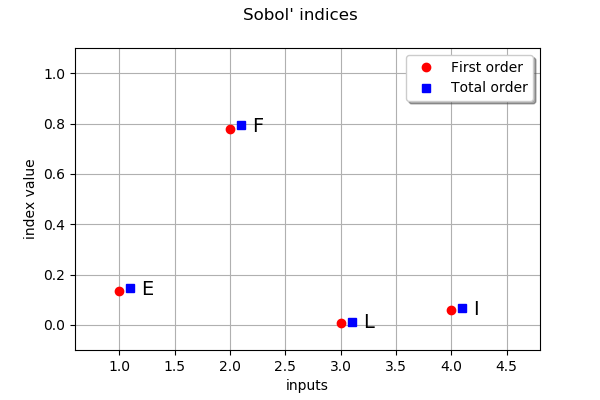

In [19]:
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = g.getInputDescription()
ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)

## Exercice 1 : pourquoi éviter le calcul du R2

L'objectif de cet exercice est de clarifier le rôle d'un plan d'expériences d'apprentissage en comparaison d'un plan d'expériences de validation. A travers le calcul des coefficients $R^2$ et $Q^2$, nous analysons le problème du surapprentissage d'un métamodèle.

Soit $\left\{x^{(j)}_a\right\}_{j=1,...,n}$ un échantillon i.i.d. du vecteur aléatoire $X$ que nous allons utiliser pour la phase d'apprentissage du métamodèle. 

On note $g$ le modèle et $\tilde{g}$ le métamodèle. 

Soient 
$$
y^{(j)}_a = g\left(x^{(j)}_a\right), \qquad \tilde{y}^{(j)}_a = \tilde{g}\left(x^{(j)}_a\right)
$$
pour $j=1,...,n$ les sorties du modèle et du métamodèle sur la base d'apprentissage. 

Supposons que le plan d'expériences $\left\{x^{(j)}_a\right\}_{j=1,...,n}$ est utilisé pour estimer les coefficients d'un modèle de regression linéaire tel qu'un métamodèle de chaos polynomial par exemple. Dans ce contexte, le coefficient $R^2$ est 
$$
R^2(g(x_a),\tilde{g}(x_a)) = 1 - \frac{ \sum_{j=1}^N \left( y^{(j)}_a - \tilde{y}^{(j)}_a \right)^2  }{ \sum_{j=1}^N \left( y^{(j)}_a - \bar{y}_a \right)^2 }
$$
où $\bar{y}_a = \frac{1} {N} \sum_{i=1}^N y^{(j)}_a$.

Supposons qu'un second plan d'expériences de validation du métamodèle est généré : $\left\{x^{(j)}_v\right\}_{j=1,...,n}$. L'objectif de ce second plan d'expériences est de tester le métamodèle sur des points d'entrées que le métamodèle n'a pas considéré pour estimer ses coefficients.

Soient $g(x_v)$ et $\tilde{g}(x_v)$ les sorties du modèle et du métamodèle sur le plan d'expériences de validation. 
Dans ce contexte, le coefficient $Q^2$ est égal au coefficient $R^2$ appliqué au plan d'expériences de validation :
$$
Q^2 = R^2(g(x_v),\tilde{g}(x_v)).
$$

Dans le contexte de tout métamodèle, et en particulier du chaos polynomial, il est plus prudent d'utiliser le coefficient $Q^2$ pour vérifier la qualité du métamodèle. En effet, lorsque le nombre de coefficients dans le chaos polynomial est suffisamment grand relativement à la taille du plan d'expériences, le coefficient $R^2$ peut laisser penser à un modèle de bonne qualité (i.e. proche de 1), mais le coefficient $Q^2$ peut révéler un modèle de mauvaise qualité (i.e. proche de 0). Cette situation est caractéristique d'un surapprentrissage.

- Utiliser la méthode `getRelativeErrors` de l'objet `result` (de type `FunctionalChaosResult`). 
Cette fonction retourne la valeur de 
$$
\frac{ \sum_{j=1}^N \left( y^{(j)}_a - \tilde{y}^{(j)}_a \right)^2  }{ \sum_{j=1}^N \left( y^{(j)}_a - \bar{y}_a \right)^2 }
$$
- Calculer le coefficient $R^2$. 
- Qu'observez-vous ?

## Exercice 2 : décroissance des coefficients

La fonction suivante produit un graphique présentant l'évolution de la valeur absolue des coefficients du chaos polynomial en fonction du degré de chaque terme polynomial dans la décomposition.

In [22]:
def plotCoefficientValueVSDegree(polynomialChaosResult):
    # Get coefficients
    coefficients = polynomialChaosResult.getCoefficients()
    abscoeff = [abs(coefficients[i][0]) for i in range(len(coefficients))]
    # Get total degree
    indices = result.getIndices()
    nbcoeffs = indices.getSize()
    total_p = []
    for k in range(nbcoeffs):
        multiindex = enumfunc(indices[k])
        totaldegree = sum(multiindex)
        total_p.append(totaldegree)
    #
    graph = ot.Graph("Polynomial chaos result","Total polynomial degree","Coefficient absolute value",True)
    cloud = ot.Cloud(total_p,abscoeff)
    graph.add(cloud)
    return graph

Utiliser la fonction `plotCoefficientValueVSDegree` sur le résultat du chaos polynomial : qu'observez-vous ?

## Exercice 3 : réduction de la taille du plan d'expériences d'apprentissage

* Use an experimental design of size __N = 25__. 
* Rerun the analysis
* Compute the $Q^2$ predictivity factor.
* Plot the metamodel validation graphics.
* What should we conclude ? 
* Can you identify 4 ways to improve the quality of the metamodel ? 

## Exercice 4 : utilisation d'une règle d'énumération hyperbolique

The hyperbolic enumeration scheme reduces the number of candidate polynomials for a given maximum degree.

* Use the `HyperbolicAnisotropicEnumerateFunction`  with the following parameters:
  - hyperbolic parameter $q=0.6$
  - highest polynomial degree $p=5$

In order to find the solution, you may use the following template, where you must replace the `TODO` sections with valid Python code.

```
dim_input = 4
polyColl = ot.PolynomialFamilyCollection(dim_input)
polyColl[0] = ot.StandardDistributionPolynomialFactory(TODO)
polyColl[1] = ot.StandardDistributionPolynomialFactory(TODO) 
polyColl[2] = ot.StandardDistributionPolynomialFactory(TODO)
polyColl[3] = ot.StandardDistributionPolynomialFactory(TODO)
q = 0.6
enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(dim_input, q)
multivariateBasis = ot.OrthogonalProductPolynomialFactory(polyColl, enumerateFunction)
```

* Compare the number of candidate polynomials using hyperbolic enumeration scheme and linear enumeration. 
* Display the degree of polynomials. 
* Which polynomials are discarded by the hyperbolic scheme ?
* The following `printMultiIndices` function uses the given enumerate function and prints the multi-indices with degree less than a given maximum.

In [25]:
def printMultiIndices(enumerateFunction,maximumDegree):
    P = enumerateFunction.getStrataCumulatedCardinal(maximumDegree)
    print('Number of coefficients with degree lower than %s is %s'%(maximumDegree,P) )

    print('Total degree' + '     ' + 'Multi-index')
    for i in range(P):
        index = enumerateFunction(i)
        degree = sum(index)
        print("#%d %4d %18s" % (i,degree,index))
    return

Use the `printMultiIndices` to print the multi-indices with maximum degree less than 5.
* For a given enumerate function, the `getStrataCumulatedCardinal(maximumDegree)` method returns the number of coefficients with maximum degree lower than `maximumDegree`. Set the `maximumDegree` to 5 and consider the following list of quasi-norm parameters :
```
q_list = [0.1, 0.3, 0.6, 0.9, 1.0]
```
For each value of this quasi-norm parameter, print the number of coefficients associated with the hyperbolic enumerate function. What do you observe ?
* Set the quasi-norm parameter `q=0.6`. Consider the maximum degree equal from 1 to 10. For each maximum degree value, compare the number of coefficients associated with the linear and hyperbolic enumeration functions. What do you observe ?

## Exercice 5 : énumération hyperbolique et plan d'expériences de taille 25

* Use an hyperbolic enumeration with a training sample size equal to __N = 25__. 
* Compute the $Q^2$ coefficient. 
* Plot the metamodel validation graphics.
* Is the quality of the chaos acceptable ?

## Exercice 6 : analyse des résultats de la sélection de modèle

L'objectif de cet exercice est d'analyser les résultats de la sélection de modèle dans le but de réaliser un diagnostique de la qualité du métamodèle obtenu.

Considérons le ratio :
```
nbcoeffs / P
```
où `P` est le nombre maximal de coefficients associé à la règle d'énumération. Ce ratio entre 0 et 1 représente la proportions de termes retenus dans la méthode de sélection de modèle. 
* Si ce ratio est proche de zéro (par exemple inférieur à 0.01), alors c'est que le modèle est très creux car un faible nombre de coefficients suffit pour bien représenter la fonction. Dans ce cas, on aurait peut-être pu obtenir une qualité équivalente en utilisant un calcul plus moins coûteux en diminuant la valeur de `P`.
* Si ce ratio est proche de un (par exemple supérieur à 0.99), alors c'est que le modèle est très plein car presque tous les coefficients ont étés nécessaires pour bien représenter la fonction. Dans ce cas, on devrait peut-être améliorer la qualité en utilisant en augmentant la valeur de `P` (cela sera plus coûteux en termes de temps de calcul, sans nécessairement nécessiter de nouvelles évaluations de la fonction $g$).

L'objectif de cet exercice est d'explorer les différentes méthodes de l'objet `result`, une instance de la classe `FunctionalChaosResult`.
* Utiliser la méthode `getIndices` pour créer la variable `indices` contenant la liste des indices des coefficients sélectionnés par la méthode. Afficher ces indices.
* Utiliser la méthode `getSize` de la variable `indices` pour obtenir le nombre de coefficients sélectionnés par la méthode.
* Utiliser la méthode `getCoefficients` pour obtenir la liste des valeurs des coefficients sélectionnés par la méthode. Afficher ces coefficients.
* Calculer le ratio `nbcoeffs / P`. Quelle est la valeur obtenue ? Que peut-on conclure relativement à la qualité du métamodèle ?
* La fonction `printCoefficientsTable` suivante utilise la règle d'énumération et le résultat d'un chaos polynomial pour afficher une table présentant les multi-indices, le degré du polynôme associé et la valeur du coefficient. 

In [32]:
def printCoefficientsTable(enumerateFunction,polynomialChaosResult):
    indices = polynomialChaosResult.getIndices()
    nbcoeffs = indices.getSize()
    print("# Multi-indice : Value (Degree)")
    for k in range(nbcoeffs):
        multiindex = enumerateFunction(indices[k])
        degree = sum(multiindex)
        c = coefficients[k][0]
        print("#%d, %s (%s) : %s" % (k,multiindex,degree,c))
    return

Utiliser la fonction `printCoefficientsTable` avec les résultats du calcul. Qu'observez-vous ?